# Deploy Qwen/Qwen-Image-Edit on SageMaker using HuggingFace Inference Containers

This notebook demonstrates how to deploy [Qwen-Image-Edit](https://huggingface.co/Qwen/Qwen-Image-Edit) text to image model on Amazon SageMaker AI endpoint.

The notebook was tested in Amazon SageMaker AI Studio environment and it's recommended to run it in the Studio.

## 1. Environment preparation

In [ ]:
%pip install sagemaker==2.254.1 --upgrade --quiet --no-warn-conflicts

In [ ]:
import os
import time
import json
import boto3
import sagemaker

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()

sm_client = boto3.client("sagemaker")  # client to intreract with SageMaker
smr_client = boto3.client("sagemaker-runtime")  # client to intreract with SageMaker Endpoints
s3 = boto3.client("s3")

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {bucket}")
print(f"sagemaker session region: {region}")
print(f"boto3 version: {boto3.__version__}")
print(f"sagemaker version: {sagemaker.__version__}")

In [ ]:
model_id = "Qwen/Qwen-Image-Edit"
s3_key = f"model/{model_id}"
s3_code_key = f"{s3_key}/code"

## 2. Model and inference logic preparation

Although it's possible to deploy a model on SageMaker AI endpoint directly from the HuggingFace Hub in production scenario the model is usually deployed from Amazon S3 bucket.
To simulate the production deployment, we are going to download the model from the HF hub and upload to the S3 bucket.

Also, we are going to prepare `requirements.txt` with a list of additional Python libraries and `inference.py` which contains custom model loading and inference code.

***P.S. you can skip this step if model and required files were uploaded to the S3 previously***

### 2.1 Download model from the HF Hub

In [ ]:
from huggingface_hub import snapshot_download
from pathlib import Path

local_model_path = Path("./data")
local_model_path.mkdir(exist_ok=True)

_ = snapshot_download(repo_id=model_id, local_dir=local_model_path)

### 2.2 Upload model files to Amazon S3

In [ ]:
# enumerate local files recursively
for root, dirs, files in os.walk(local_model_path):
    for filename in files:
        local_path = os.path.join(root, filename)

        relative_path = os.path.relpath(local_path, local_model_path)
        s3_path = os.path.join(s3_key, relative_path)

        print("Uploading %s..." % s3_path)
        s3.upload_file(local_path, bucket, s3_path)

### 2.3 Prepare `requirements.txt` and `inferency.py`

In [ ]:
requirements = """git+https://github.com/huggingface/diffusers.git
transformers==4.57.3
accelerate==1.12.0
peft==0.17.1
"""
file_name = "requirements.txt"
with open(file_name, 'w') as f:
    f.write(requirements)

key = f"{s3_code_key}/{file_name}"
s3.upload_file(file_name, bucket, key)

##### Please note that we are using `balanced` device map and it assumes that we use 4 GPU instance with 48GB per GPU. Please adjust the map based on your target deployment

In [ ]:
inference = """import json
import time
import os
import random
import base64
import logging
from io import BytesIO
from PIL import Image
import torch
from diffusers import QwenImageEditPipeline
from diffusers.utils import load_image

device = "cuda"
torch_dtype = torch.bfloat16

def encode_images(images):
    encoded_images = []
    for image in images:
        buffer = BytesIO()
        image.save(buffer, format="JPEG")
        img_str = base64.b64encode(buffer.getvalue())
        encoded_images.append(img_str.decode("utf8"))

    return encoded_images


def model_fn(model_dir):
    pipe = QwenImageEditPipeline.from_pretrained(model_dir, 
                                                device_map="balanced",
                                                max_memory={0: "48GB", 1: "48GB", 2: "48GB", 3: "48GB"},
                                                torch_dtype=torch_dtype)
    #pipe.enable_model_cpu_offload()
    #pipe.to(device)

    return pipe


def predict_fn(data, pipe):
    print("inference started")

    positive_magic = ", Ultra HD, 4K, cinematic composition."
    default_prompt =  '''A coffee shop entrance features a chalkboard sign reading "Qwen Coffee 😊 $2 per cup," with a neon light beside it displaying "通义千问". Next to it hangs a poster showing a beautiful Chinese woman, and beneath the poster is written "π≈3.1415926-53589793-23846264-33832795-02384197"'''
    default_neg_prompt = " "
    default_width = 1664
    default_height = 928
    default_num_steps = 20
    default_cfg_scale = 4.0
    default_seed = 42

    base64_encoded = data.pop("image")

    # Convert base64 back to PIL Image
    image_data = base64.b64decode(base64_encoded)
    image = Image.open(BytesIO(image_data)).convert("RGB")

    prompt = data.pop("prompt", default_prompt)
    negative_prompt = data.pop("negative_prompt", default_neg_prompt)
    height = int(data.pop("height", default_height))
    width = int(data.pop("width", default_width))
    num_steps = int(data.pop("num_steps", default_num_steps))
    true_cfg_scale = float(data.pop("true_cfg_scale", default_cfg_scale))
    seed = int(data.pop("seed", default_seed))

    start_time = time.perf_counter()

    images = pipe(
        image=image,
        prompt=prompt,
        num_inference_steps=num_steps,
        true_cfg_scale=true_cfg_scale,
        generator=torch.Generator(device=device).manual_seed(seed)
    ).images

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    print(f"Execution time - in PREDICT : {elapsed_time:.6f} seconds")

    encoded_images = encode_images(images)

    return {"data": encoded_images}

"""
file_name = "inference.py"
with open(file_name, 'w') as f:
    f.write(inference)

key = f"{s3_code_key}/{file_name}"
s3.upload_file(file_name, bucket, key)

## 3. Model deployment

Model deployment on Amazon SageMaker AI consist of 3 steps:
- [create model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_model.html) object (serving container and location of model artifacts)
- [create endpoint configuration](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/create_endpoint_config.html) (endpoint type: real-time/async, instance type and count)
- [create endpoint](https://boto3.amazonaws.com/v1/documentation/api/1.40.48/reference/services/sagemaker-runtime/client/invoke_endpoint_async.html)

In [ ]:
inference_image = f"763104351884.dkr.ecr.{region}.amazonaws.com/huggingface-pytorch-inference:2.6.0-transformers4.49.0-gpu-py312-cu124-ubuntu22.04"

instance = {"type": "ml.g6e.12xlarge", "num_gpu": 4}
model_name = f"model-{time.strftime('%y%m%d-%H%M%S')}"
endpoint_name = model_name
endpoint_config_name = model_name
timeout = 600
variant_name = "main"

model_data_source = {
    'S3DataSource': {
        'S3Uri': f"s3://{bucket}/{s3_key}/",
        'S3DataType': 'S3Prefix',
        'CompressionType': 'None',
    }
}

In [ ]:
model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image,
        "ModelDataSource": model_data_source,
        "Environment": {
            "SAGEMAKER_MODEL_SERVER_WORKERS": "1"
        }
    },
)


**We are going to use RT endpoint.**


In [ ]:
config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": variant_name,
            "ModelName": model_name,
            "InstanceType": instance["type"],
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": timeout,
        },
    ],
)

endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

_ = sess.wait_for_endpoint(endpoint_name)

## 4. Inference examples

**Please note that the generated video file will be placed in `{bucket}/{key}` specified in the invocation request**

In [ ]:
import base64
from PIL import Image
import io

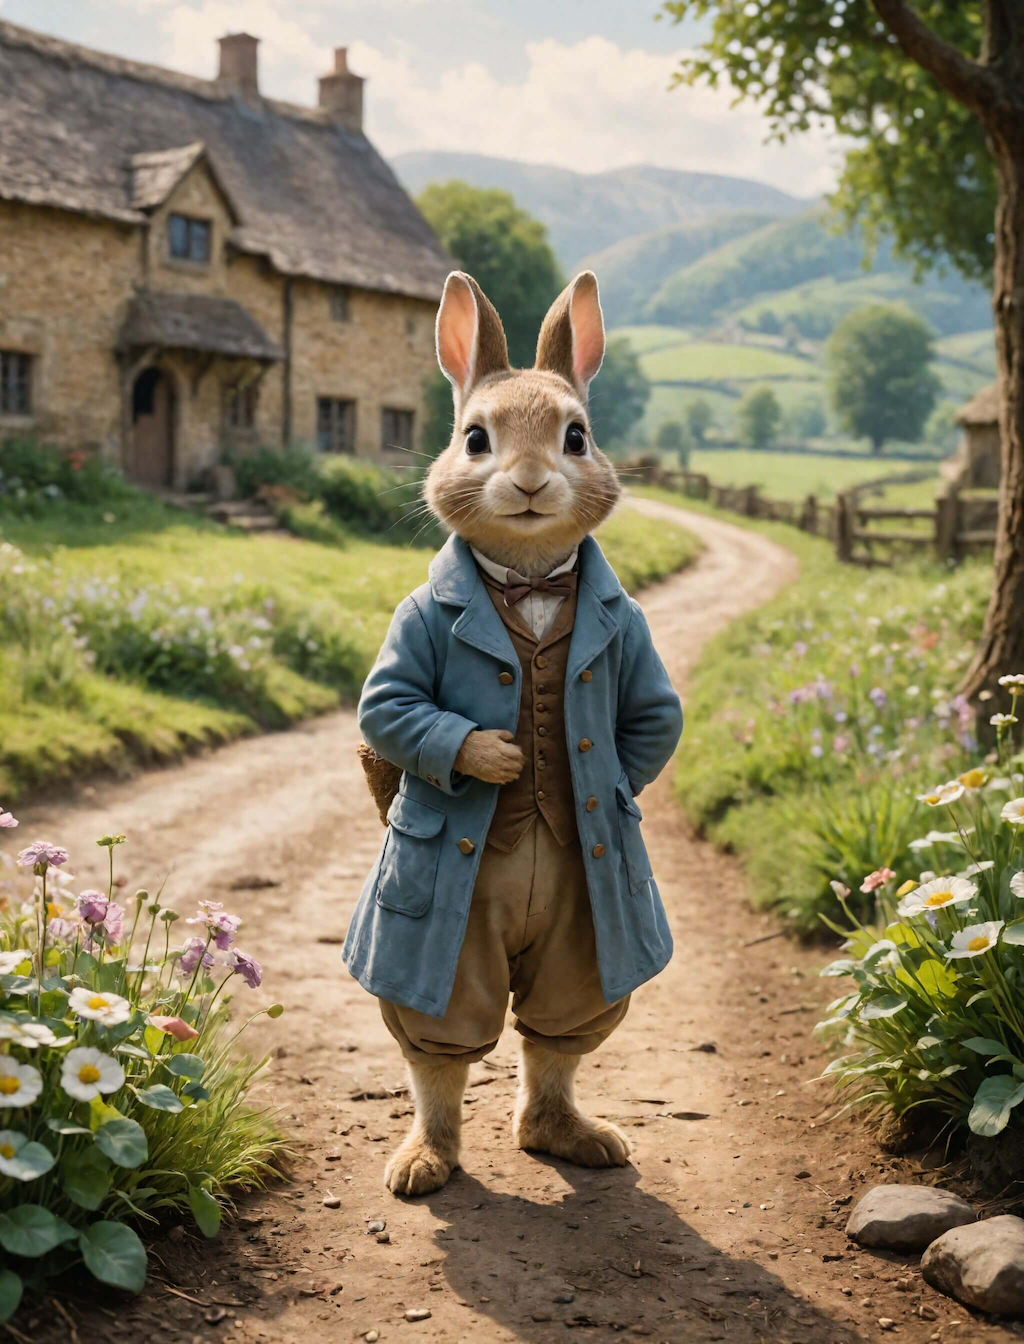

In [17]:
with open('./rabbit_sm.png', 'rb') as image_file:
    base64_encoded = base64.b64encode(image_file.read()).decode('utf-8')
image_data = base64.b64decode(base64_encoded)
image = Image.open(io.BytesIO(image_data)).convert("RGB")
image.show()

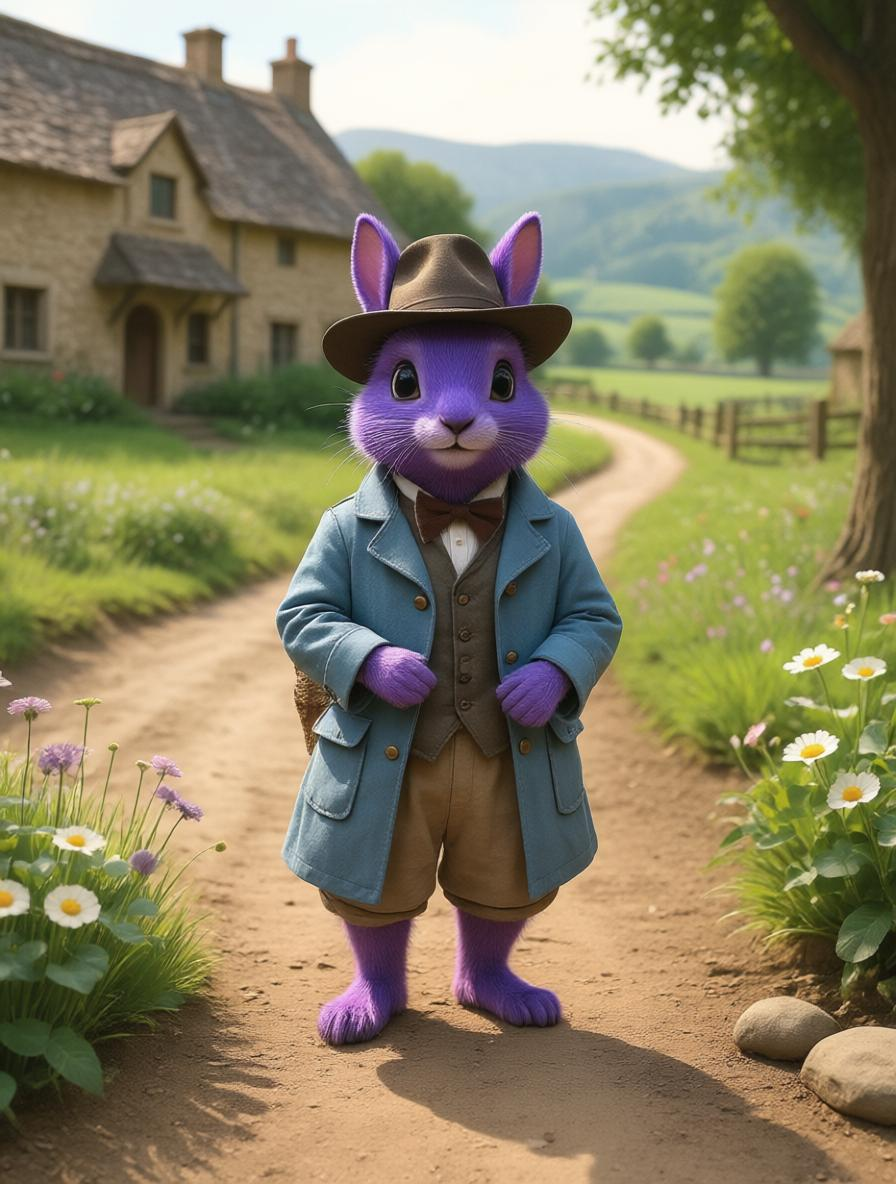

In [18]:
payload = {
    "prompt": "Change rabbit head, arms and legs to purple color, leave cloth colors unchanged, add hat to the rabbit",
    "guidance_scale": 0,
    "num_steps": 30,
    "seed": 41,
    "image": base64_encoded
}

res = smr_client.invoke_endpoint(EndpointName=endpoint_name,
                                 Body=json.dumps(payload),
                                 ContentType="application/json")
response = json.loads(res["Body"].read().decode("utf8")) 
base64_image = response["data"][0]
image_bytes = base64.b64decode(base64_image)
# Create a PIL Image from the bytes
generated_image = Image.open(io.BytesIO(image_bytes))
# Display the image (this will open in your default image viewer)
generated_image.show()
generated_image.save("rabbit_sm_edited.png")

## 5. Cleanup

In [19]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_config_name)
sess.delete_model(model_name)